# Prepare disconnection of "sources of many high dimensional simplices"

We want to select cells that are "sources of many high dimensional simplices" and are highly reliable in order to disconnect their outputs and check if this decreases their reliability

ℹ️ Related ticket: [[ACCS-19](https://bbpteam.epfl.ch/project/issues/browse/ACCS-19)]

In [1]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
# Load pre-selected source neurons of high-dim simplices
#  Keys corresponding to simplex dimension: 4, 5, 6
nrn_file = '/gpfs/bbp.cscs.ch/project/proj102/egas/reliability/sources_of_many_high_dim_simplices.pkl'
dim_keys = [4, 5, 6]

with open(nrn_file, 'rb') as f:
    nrn_high_dim_src = pickle.load(f)

In [3]:
# Load pre-computed reliabilities
reliab_file = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA/reliability/reliability_exc_sigma10ms.npz'
reliab_exc = np.load(reliab_file)['reliab_centered']
gids_exc = np.load(reliab_file)['gids']

In [4]:
# Load reliabilities for pre-selected source neurons
reliab_high_dim_src = {}
for k in dim_keys:
    reliab_sel = []
    for gid in nrn_high_dim_src[k]:
        gid_sel = np.where(gids_exc == gid)[0]
        if len(gid_sel) == 0:
            reliab_sel.append(np.nan)
        else:
            reliab_sel.append(reliab_exc[gid_sel[0]])
    reliab_high_dim_src[k] = np.array(reliab_sel)

print('Reliabilities:')
for k in dim_keys:
    print(f'{k}: {np.sum(np.isfinite(reliab_high_dim_src[k]))} of {len(reliab_high_dim_src[k])} values, min={np.nanmin(reliab_high_dim_src[k]):.3f}, max={np.nanmax(reliab_high_dim_src[k]):.3f}, mean={np.nanmean(reliab_high_dim_src[k]):.3f}')

Reliabilities:
4: 99 of 100 values, min=-0.000, max=0.658, mean=0.251
5: 100 of 100 values, min=-0.000, max=0.658, mean=0.216
6: 96 of 100 values, min=-0.000, max=0.677, mean=0.240


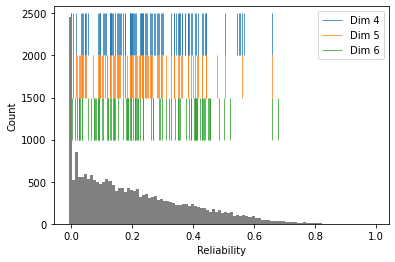

In [5]:
# Plot all reliabilities
plt.figure()
plt.hist(reliab_exc, bins=100, color='grey')
plt.ylim(plt.ylim())
for k, c, y in zip(dim_keys, ['tab:blue', 'tab:orange', 'tab:green'], np.linspace(2000, 1000, 3)):
    plt.vlines(reliab_high_dim_src[k], ymin=y, ymax=y + 500, color=c, alpha=0.75, lw=1, zorder=0, label=f'Dim {k}')
# plt.grid()
plt.xlabel('Reliability')
plt.ylabel('Count')
plt.legend()
plt.show()

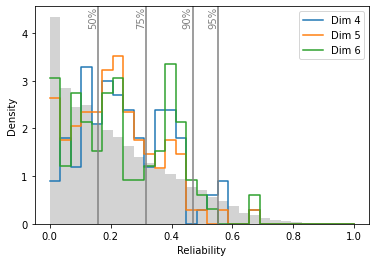

In [6]:
# Plot reliability histograms
bins = np.linspace(0, 1, 30)
plt.figure()
plt.hist(reliab_exc, bins=bins, density=True, color='lightgrey')
for k in dim_keys:
    hist_dens = np.histogram(reliab_high_dim_src[k], bins=bins, density=True)[0]
    plt.step(bins, np.hstack([hist_dens[0], hist_dens]), label=f'Dim {k}')
for prc in [50, 75, 90, 95]:
    plt.axvline(np.percentile(reliab_exc, prc), color='grey')
    plt.text(np.percentile(reliab_exc, prc), np.max(plt.ylim()), f'{prc}%', rotation=90, color='grey', ha='right', va='top')
plt.xlabel('Reliability')
plt.ylabel('Density')
plt.legend()
plt.show()

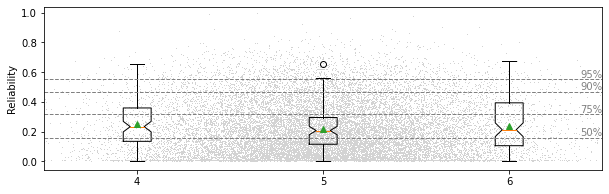

In [7]:
# Plot selected reliabilities
np.random.seed(0)
plt.figure(figsize=(10, 3))
plt.plot(np.random.randn(len(reliab_exc)) * 0.5 + np.mean(dim_keys), reliab_exc, ',', color='lightgrey')
for idx, k in enumerate(dim_keys):
    plt.boxplot(reliab_high_dim_src[k][np.isfinite(reliab_high_dim_src[k])], positions=[k], showmeans=True, notch=True)
plt.xticks(dim_keys)
plt.xlim([min(dim_keys) - 0.5, max(dim_keys) + 0.5])

for pct in [50, 75, 90, 95]:
    plt.plot(plt.xlim(), np.full(2, np.percentile(reliab_exc, pct)), '--', color='grey', linewidth=1)
    plt.text(max(plt.xlim()), np.percentile(reliab_exc, pct), f'{pct}%', color='grey', ha='right', va='bottom')
# plt.grid()
plt.ylabel('Reliability')
plt.show()

Select top-dim GIDs with high reliability

In [9]:
# Create table with GIDs above given reliability percentile
prc_list = np.arange(50, 96, 5)
print('Reliability percentiles:')
for prc in prc_list:
    print(f'{prc}%: {np.percentile(reliab_exc, prc):.2f}')

gid_table = {}
for kidx, k in enumerate(dim_keys):
    gid_table[k] = []
    for pidx, prc in enumerate(prc_list):
        gid_table[k].append(list(nrn_high_dim_src[k][reliab_high_dim_src[k] > np.percentile(reliab_exc, prc)]))
gid_table = pd.DataFrame.from_dict(gid_table, orient='index', columns=prc_list)
gid_table

Reliability percentiles:
50%: 0.16
55%: 0.19
60%: 0.21
65%: 0.24
70%: 0.28
75%: 0.32
80%: 0.36
85%: 0.41
90%: 0.47
95%: 0.55


,50,55,60,65,70,75,80,85,90,95
4,"[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89391, 89373, 91372, 91628, 88146, 923...","[81724, 89373, 91372, 91628, 88146, 92301, 896...","[89373, 91628, 88146, 92301, 67997, 93645, 815...","[91628, 88146, 92301, 75894, 74042, 73919, 79868]","[91628, 92301, 75894]"
5,"[81724, 89391, 91628, 82979, 88146, 89373, 923...","[81724, 89391, 91628, 82979, 88146, 89373, 923...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 89391, 91628, 88146, 89373, 92301, 913...","[81724, 91628, 88146, 89373, 92301, 91372, 818...","[91628, 88146, 89373, 92301, 81862, 88869, 936...","[91628, 88146, 92301, 88869]","[91628, 92301]"
6,"[92907, 88807, 89391, 81724, 75456, 75960, 815...","[92907, 88807, 89391, 81724, 75456, 75960, 878...","[92907, 89391, 81724, 75456, 75960, 87894, 903...","[89391, 81724, 75456, 87089, 90174, 75416, 773...","[89391, 81724, 75456, 87089, 90174, 75416, 830...","[89391, 81724, 75456, 87089, 90174, 75416, 911...","[81724, 90174, 75416, 91149, 92301, 74934, 754...","[90174, 92301, 74934, 75489, 75880, 76032, 818...","[92301, 75880, 91150, 78761, 80932]","[92301, 80932]"


In [10]:
# Create table with GID counts above given reliability percentile
count_table = np.full([len(dim_keys), len(prc_list)], -1)
for pidx, prc in enumerate(prc_list):
    for kidx, k in enumerate(dim_keys):
        count_table[kidx, pidx] = len(gid_table.loc[k, prc])
count_table = pd.DataFrame(count_table, columns=prc_list, index=dim_keys)
count_table

,50,55,60,65,70,75,80,85,90,95
4,68,64,54,46,39,33,25,14,7,3
5,62,58,48,37,30,23,17,10,4,2
6,61,55,48,41,38,34,27,19,5,2


In [11]:
# Unique GID + counts (all dims)
gids_prc = {}
for prc in prc_list:
    gids_prc[prc] = np.unique(np.concatenate(list(gid_table[prc])),return_counts=True)
[len(gids_prc[prc][0]) for prc in prc_list]

[135, 125, 107, 89, 77, 66, 51, 32, 12, 4]

In [16]:
# Unique GID + counts (dims 5, 6)
gids_prc = {}
for prc in prc_list:
    gids_prc[prc] = np.unique(np.concatenate(list(gid_table[prc].loc[[5, 6]])), return_counts=True)
[len(gids_prc[prc][0]) for prc in prc_list]

[112, 103, 88, 72, 62, 52, 40, 27, 8, 3]

In [138]:
# # ***SELECTION 1: 10 cells***
# # Selecting 8 dim 5/6 GIDs with relibailities above 90-percentile + 2 random ones from dim 4
# np.random.seed(1234)
# gids_sel56 = gids_prc[90][0]
# gids_sel4 = np.random.choice(np.setdiff1d(gid_table[90].loc[4], gids_prc[90][0]), 2, replace=False)
# gids_sel = list(np.unique(np.hstack([gids_sel56, gids_sel4])))

# print(f'{len(gids_sel)} selected top-dim GIDs with high reliability:')
# print(gids_sel)


10 selected top-dim GIDs with high reliability:
[73919, 74042, 75880, 78761, 80932, 88146, 88869, 91150, 91628, 92301]


In [212]:
# # Print reliabilities of selected cells
# reliab_sel = reliab_exc[[np.where(gids_exc == gid)[0][0] for gid in gids_sel]]
# print('Reliabilities of selected GIDs:')
# print([f'{r:.2f}' for r in reliab_sel])

Reliabilities of selected GIDs:
['0.55', '0.54', '0.48', '0.50', '0.68', '0.50', '0.48', '0.52', '0.56', '0.66']


In [17]:
# ***SELECTION 2: ~100 cells***
# Selecting all dim 5/6 GIDs with relibailities above 50-percentile
gids_sel = list(gids_prc[50][0])

print(f'{len(gids_sel)} selected top-dim GIDs with high reliability:')
print(gids_sel)


112 selected top-dim GIDs with high reliability:
[66565, 67581, 67997, 70310, 71832, 73031, 73540, 74934, 75084, 75391, 75416, 75456, 75489, 75806, 75880, 75960, 76032, 76470, 77358, 77424, 77522, 77524, 78008, 78304, 78395, 78695, 78761, 79830, 79842, 79854, 80514, 80528, 80554, 80630, 80932, 81413, 81552, 81580, 81724, 81862, 82096, 82107, 82127, 82337, 82377, 82725, 82866, 82979, 83013, 83134, 83137, 83175, 83271, 83866, 84004, 84241, 84311, 84375, 84520, 84777, 84922, 84936, 85326, 85387, 85535, 86143, 87089, 87437, 87605, 87894, 87926, 88046, 88146, 88663, 88696, 88807, 88869, 89010, 89016, 89173, 89311, 89373, 89391, 89603, 89626, 89881, 90040, 90133, 90174, 90368, 90505, 90548, 90622, 90986, 91149, 91150, 91372, 91498, 91628, 91759, 91886, 92019, 92301, 92361, 92363, 92653, 92896, 92907, 93180, 93314, 93645, 93857]


In [21]:
# Print reliabilities of selected cells
reliab_sel = reliab_exc[[np.where(gids_exc == gid)[0][0] for gid in gids_sel]]
print('Reliabilities of selected GIDs:')
print([f'{r:.2f}' for r in reliab_sel])
print(f'MIN={np.min(reliab_sel):.2f}; MAX={np.max(reliab_sel):.2f}; MEAN={np.mean(reliab_sel):.2f}')

Reliabilities of selected GIDs:
['0.28', '0.29', '0.41', '0.27', '0.45', '0.32', '0.36', '0.41', '0.18', '0.45', '0.41', '0.35', '0.44', '0.40', '0.48', '0.23', '0.45', '0.41', '0.26', '0.30', '0.21', '0.39', '0.43', '0.45', '0.41', '0.19', '0.50', '0.21', '0.33', '0.19', '0.43', '0.38', '0.41', '0.18', '0.68', '0.19', '0.18', '0.43', '0.41', '0.43', '0.34', '0.27', '0.22', '0.33', '0.21', '0.23', '0.20', '0.19', '0.29', '0.21', '0.41', '0.23', '0.26', '0.30', '0.29', '0.22', '0.36', '0.19', '0.24', '0.20', '0.28', '0.29', '0.41', '0.26', '0.24', '0.18', '0.35', '0.19', '0.26', '0.22', '0.22', '0.20', '0.50', '0.17', '0.21', '0.21', '0.48', '0.40', '0.21', '0.20', '0.35', '0.44', '0.35', '0.31', '0.38', '0.25', '0.27', '0.25', '0.42', '0.22', '0.22', '0.20', '0.43', '0.25', '0.39', '0.52', '0.38', '0.23', '0.56', '0.34', '0.29', '0.36', '0.66', '0.34', '0.17', '0.38', '0.18', '0.23', '0.24', '0.20', '0.44', '0.34']
MIN=0.17; MAX=0.68; MEAN=0.32


Prepare cell target file for simulations

In [22]:
# Prepare & write target file (using hashed target name, to avoid confusion in case of different selections)
hash_obj = hashlib.shake_128()
hash_obj.update(str(gids_sel).encode('UTF-8'))
hash_code = hash_obj.hexdigest(4).upper()

target_file = '../workflows/top_dim_high_reliab_cells.target'
target_name = 'TopDimHighReliab_' + hash_code
with open(target_file, 'a') as fid:
    gids_str = ' '.join([f'a{gid}' for gid in gids_sel])
    target_str = f'Target Cell {target_name}\n{{\n{gids_str}\n}}\n'
    fid.write(target_str)
print(f'Cell target "{target_name}" with {len(gids_sel)} cells written to {target_file}')

Cell target "TopDimHighReliab_F97E29B9" with 112 cells written to ../workflows/top_dim_high_reliab_cells.target


### Prepare "Regular uniform block design"

In [158]:
r = 30 # Total number of sims a given cell is manipulated (=sum of columns)
k = 10 # Number of manipulated cells at a time, i.e., within one simulation (=sum of rows)
v = 30 # Total number of manipulated cells

b = v * r / k # Total number of sims
assert b == int(b), 'ERROR: Total number of sims not integer number!'
b = int(b)

In [159]:
def check_sums(mat, row_sum, col_sum):
    return np.all(np.sum(mat, 0) == row_sum) and np.all(np.sum(mat, 1) == col_sum)

In [160]:
block_table = np.zeros((v, b), dtype='bool')
for i in range(np.round(b / r).astype(int)):
    block_table[i * k : (i + 1) * k, i * r : (i + 1) * r] = True
assert check_sums(block_table, k, r), 'ERROR: Row/colum sum mismatch!'

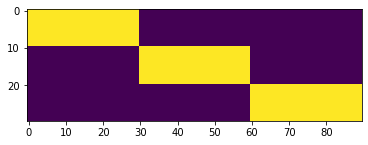

In [161]:
plt.figure()
plt.imshow(block_table)
plt.show()

In [162]:
np.random.seed(0)
for c1 in range(block_table.shape[1]):
    for ik in range(k):
        r1 = np.random.choice(np.where(block_table[:, c1])[0], 1)[0]
        c2 = np.random.choice(np.where(~block_table[r1, :])[0], 1)[0]
        r2 = np.random.choice(np.where(np.logical_and(block_table[:, c2], ~block_table[:, c1]))[0], 1)[0]
        block_table[r1, c1] = False
        block_table[r2, c1] = True
        block_table[r1, c2] = True
        block_table[r2, c2] = False
        assert check_sums(block_table, k, r), 'ERROR: Row/colum sum mismatch!'

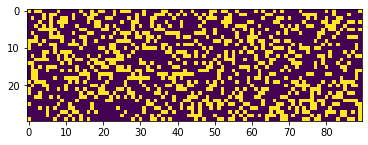

In [163]:
plt.figure()
plt.imshow(block_table)
plt.show()